# Predicting Video Games sales - Regression Tree

In [40]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

# Load data and analyze features

In [2]:
path = 'data/vgsales.csv'
raw_data = pd.read_csv(path)
raw_data

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16594,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01


## Check null values and correlation

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [19]:
# get summary of null values in each column

# Create a summary DataFrame
missing_data_summary = pd.DataFrame({
    'Missing Count': raw_data.isnull().sum(),
    'Percentage Missing (%)': round(raw_data.isnull().mean() * 100, 2)
})

# Sort by percentage missing in descending order
missing_data_summary = missing_data_summary.sort_values(by='Percentage Missing (%)', ascending=False)

print(missing_data_summary)


              Missing Count  Percentage Missing (%)
Year                    271                    1.63
Publisher                58                    0.35
Rank                      0                    0.00
Name                      0                    0.00
Platform                  0                    0.00
Genre                     0                    0.00
NA_Sales                  0                    0.00
EU_Sales                  0                    0.00
JP_Sales                  0                    0.00
Other_Sales               0                    0.00
Global_Sales              0                    0.00


Missing values in Year and Publisher
* Fill Year NaN with median
* FIll Publisher NaN with 'Unknown'

<Axes: title={'center': 'Feature Importance'}>

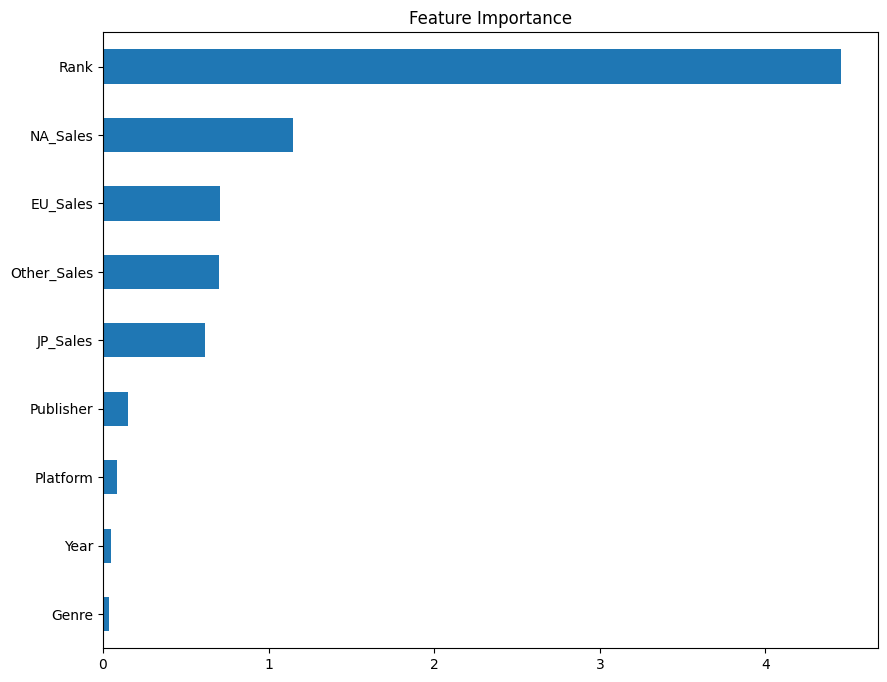

In [22]:
# handle missing values
raw_data['Year'] = raw_data['Year'].fillna(raw_data['Year'].median())
raw_data['Publisher'] = raw_data['Publisher'].fillna('Unknown')

# temporaly encode categorical features to check correlation
df_temp = raw_data.drop(columns=['Global_Sales', 'Name']).copy()
for col in df_temp.select_dtypes(include=['object']):
    df_temp[col] = LabelEncoder().fit_transform(df_temp[col])

# calculate info gain
importances = mutual_info_regression(df_temp, LabelEncoder().fit_transform(raw_data['Global_Sales']))

# display
feature_importances = pd.Series(importances, index=df_temp.columns)
feature_importances.sort_values().plot(kind='barh', title='Feature Importance' ,figsize=(10,8))

# Extract X and Y

In [37]:
X = raw_data.drop(['Global_Sales', 'Name', 'Rank'], axis=1)
y = raw_data['Global_Sales']


In [38]:
# separate categorical and numerical features

cat_features = [
    'Platform',
    'Genre',
    'Publisher', 
    'Year']
num_features = X.drop(columns=cat_features).columns.tolist()

X[cat_features] = X[cat_features].astype(str) # ensure they are strings for encoding

# Train/Test Split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## OneHotEncode Categorical Features

In [41]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# fit and transform training data, transform test data
X_train_encoded = encoder.fit_transform(X_train[cat_features])
X_test_encoded = encoder.transform(X_test[cat_features])